In [29]:
import os
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns

In [30]:
RESULTS_FOLDER = "../results"
DATA_FOLDER = "../data"
TEMP_FOLDER = "../tmp"

Normalized Predictions: [5. 2. 5. ... 3. 3. 4.]
train: 0       3
1       1
2       3
3       1
4       6
       ..
5766    5
5767    1
5768    1
5769    2
5770    9
Name: decile_score, Length: 5771, dtype: int64
Mean Squared Error: 5.044879570265119
R-squared Score: 0.37350941834997764
Intercept (w_0): 4.498353838156299
Coefficients (w_1, w_2, ...): [-1.0988714   0.21162846  0.80234679  0.02079777 -0.75142655  0.09758879
 -0.09758879]
                   Feature  Coefficient
0                      age    -1.098871
1             priors_count     0.211628
2      history_of_violence     0.802347
3  days_b_screening_arrest     0.020798
4  socioeconomic_stability    -0.751427
5        c_charge_degree_F     0.097589
6        c_charge_degree_M    -0.097589


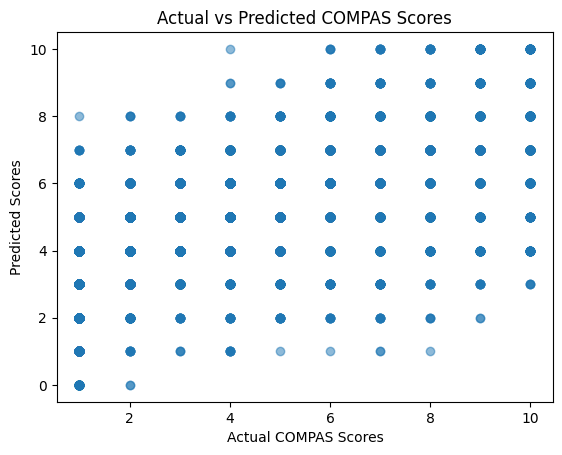

Correlation Matrix:
                Actual COMPAS  Predicted  two_year_recid
Actual COMPAS        1.000000   0.707202        0.350693
Predicted            0.707202   1.000000        0.381754
two_year_recid       0.350693   0.381754        1.000000


In [33]:

# Load the dataset (replace 'train_dataset.csv' with your dataset path)
df_train_path = os.path.join(DATA_FOLDER, 'train_dataset.csv')
df_train = pd.read_csv(df_train_path)

# Feature Engineering

# Composite feature for history_of_violence
df_train["history_of_violence"] = (
    df_train["juv_fel_count"] + df_train["juv_misd_count"] + df_train["juv_other_count"] + df_train["priors_count"]
)

# Socioeconomic stability proxy
df_train["socioeconomic_stability"] = (1 / (1 + df_train["priors_count"])) 

# Select relevant features for the COMPAS equation
X_train = df_train[[ 
    "age", "priors_count", "history_of_violence", "days_b_screening_arrest", 
    "socioeconomic_stability", "c_charge_degree_F", "c_charge_degree_M"
]]

y_train_compas = df_train["decile_score"]
y_train = df_train["two_year_recid"] * 10

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Train the model
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_train_scaled)
# Normalize the predicted values to the range [0, 10]
#y_pred_normalized =  10 * (y_pred - y_pred.min()) / (y_pred.max() - y_pred.min())
#y_pred_normalized = 10 / (1 + np.exp(-y_pred))
y_pred_normalized =  np.clip( np.ceil(y_pred), 0, 10)



print("Normalized Predictions:", y_pred_normalized)
print("train:", y_train_compas) 


# Evaluate the model
mse = mean_squared_error(y_train_compas, y_pred_normalized)
r2 = r2_score(y_train_compas, y_pred_normalized)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

# Coefficients (interpretable weights)
print("Intercept (w_0):", model.intercept_)
print("Coefficients (w_1, w_2, ...):", model.coef_)

# Feature importance
coefficients = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": model.coef_
})
print(coefficients)

# Visualization: Actual vs Predicted
import matplotlib.pyplot as plt
plt.scatter(y_train_compas, y_pred_normalized, alpha=0.5)
plt.xlabel("Actual COMPAS Scores")
plt.ylabel("Predicted Scores")
plt.title("Actual vs Predicted COMPAS Scores")
plt.show()

# Correlation analysis
comparison = pd.DataFrame({
    "Actual COMPAS": y_test,
    "Predicted": y_pred_normalized,
    "two_year_recid": df_train.loc[y_train_compas.index, "two_year_recid"],  # Align indices
})

# Ensure only numeric columns are used for correlation
numeric_columns = comparison.select_dtypes(include=[np.number])

# Overall correlation
correlation = numeric_columns.corr()
print("Correlation Matrix:")
print(correlation)





Predicted Risk Group vs Two-Year Recidivism Summary:
two_year_recid           0     1
Predicted_Risk_Group            
Low                   1712   594
Medium                1364  1614
High                    99   388


/var/folders/2h/y479tsnx7xsdv7jvrs2zpk540000gn/T/ipykernel_32953/4164303440.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  predicted_grouped = df_train.groupby(["Predicted_Risk_Group", "two_year_recid"]).size().unstack(fill_value=0)


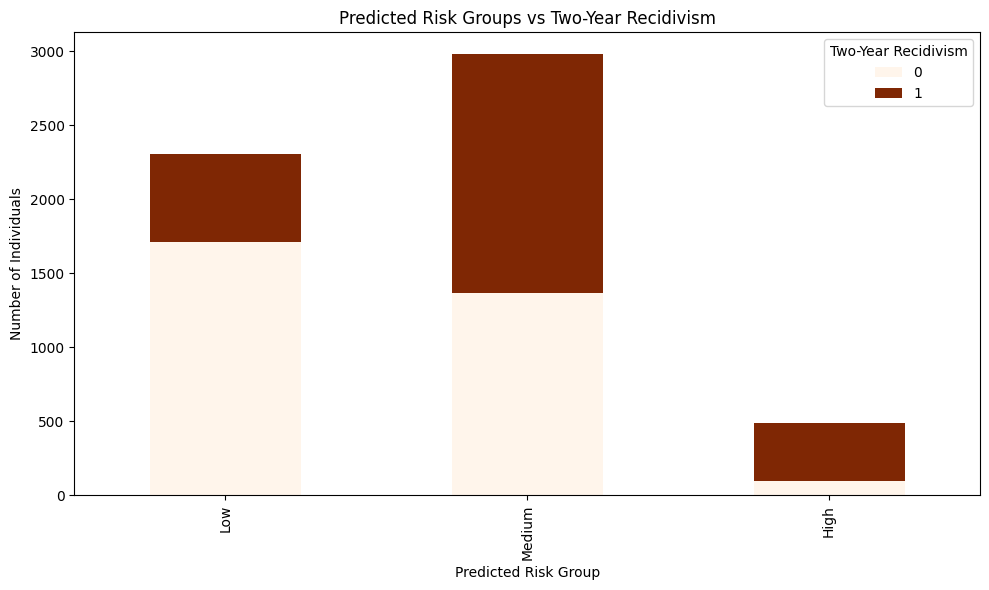

/var/folders/2h/y479tsnx7xsdv7jvrs2zpk540000gn/T/ipykernel_32953/4164303440.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  race_comparison = df_train.groupby(["race", "Predicted_Risk_Group", "two_year_recid"]).size().unstack(fill_value=0)
/var/folders/2h/y479tsnx7xsdv7jvrs2zpk540000gn/T/ipykernel_32953/4164303440.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_race = race_data.groupby(["Predicted_Risk_Group", "two_year_recid"]).size().unstack(fill_value=0)
/var/folders/2h/y479tsnx7xsdv7jvrs2zpk540000gn/T/ipykernel_32953/4164303440.py:54: FutureWarning: The default of observed=False is depre


Race-Based Comparison of Predicted Risk Groups vs Two-Year Recidivism:
two_year_recid                           0    1
race             Predicted_Risk_Group          
African-American Low                   607  247
                 Medium                761  970
                 High                   72  300
Asian            Low                    15    2
                 Medium                  2    6
                 High                    1    0
Caucasian        Low                   756  249
                 Medium                426  449
                 High                   18   65
Hispanic         Low                   198   60
                 Medium                113  117
                 High                    7   14
Native American  Low                     4    2
                 Medium                  4    2
                 High                    0    2
Other            Low                   132   34
                 Medium                 58   70
                

/var/folders/2h/y479tsnx7xsdv7jvrs2zpk540000gn/T/ipykernel_32953/4164303440.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_race = race_data.groupby(["Predicted_Risk_Group", "two_year_recid"]).size().unstack(fill_value=0)
/var/folders/2h/y479tsnx7xsdv7jvrs2zpk540000gn/T/ipykernel_32953/4164303440.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_race = race_data.groupby(["Predicted_Risk_Group", "two_year_recid"]).size().unstack(fill_value=0)
/var/folders/2h/y479tsnx7xsdv7jvrs2zpk540000gn/T/ipykernel_32953/4164303440.py:54: FutureWarning: The default of observed=False is deprecated and 

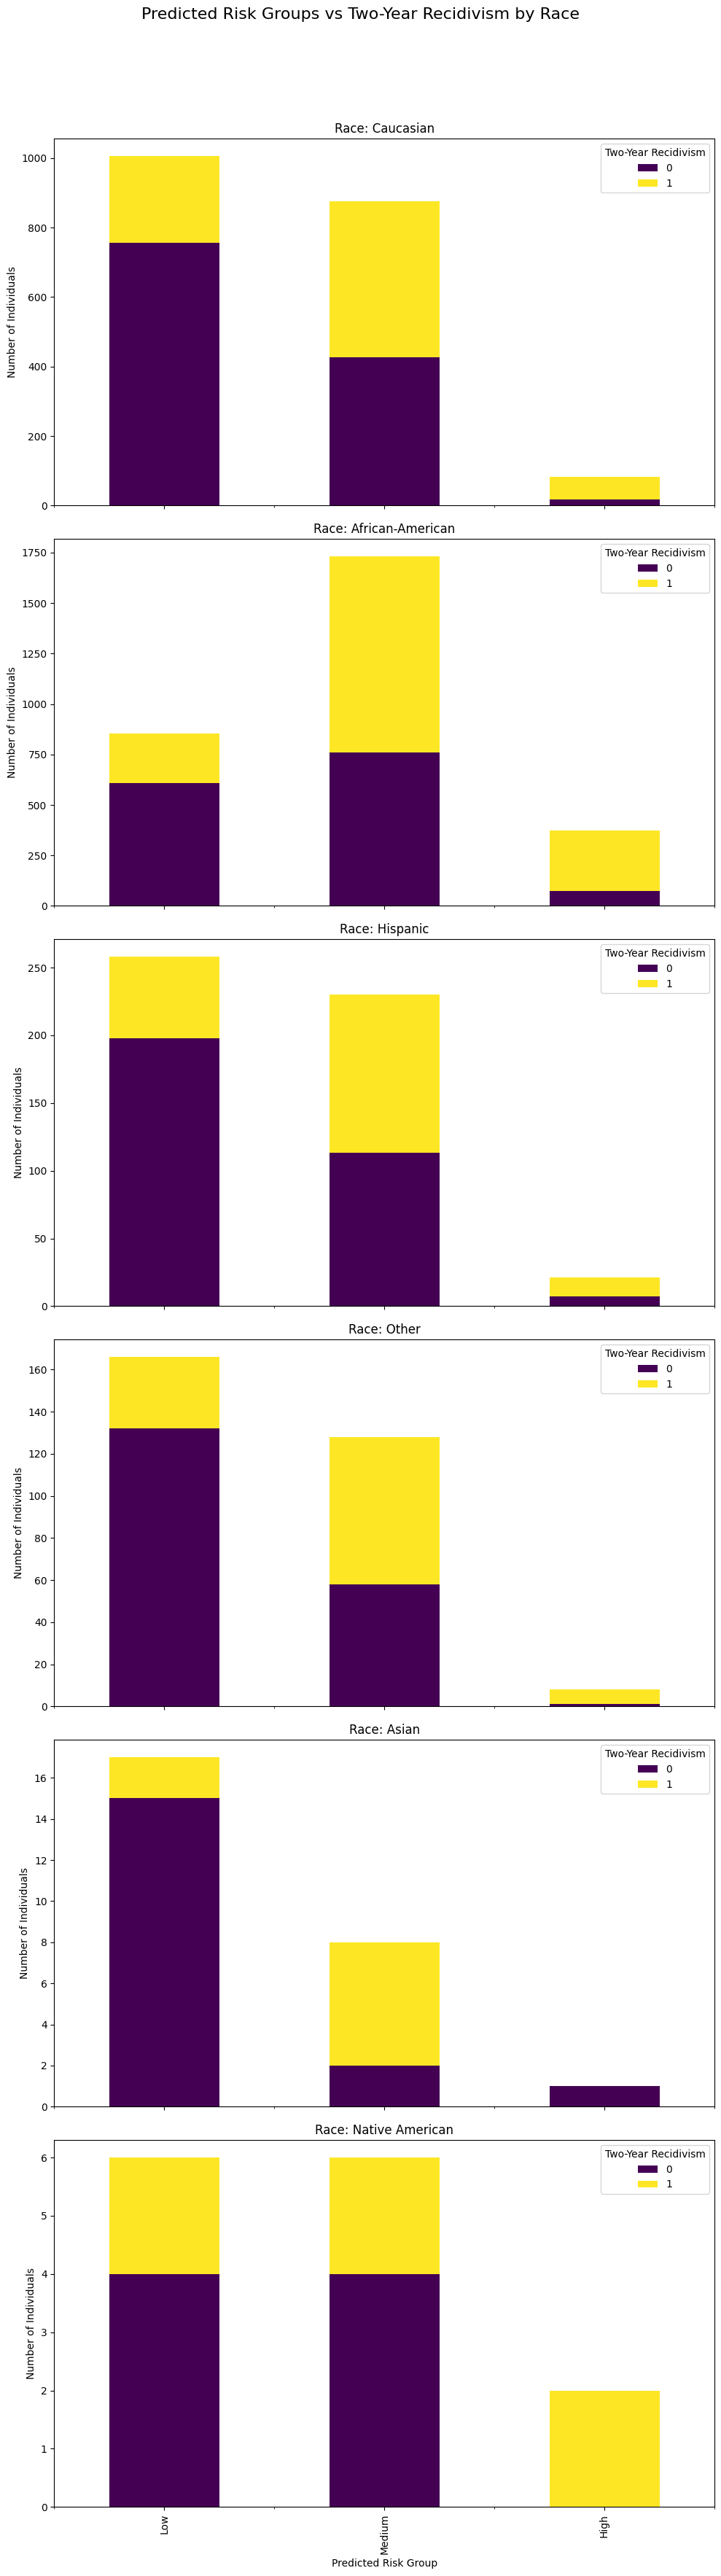

In [34]:


# Categorize predictions into risk groups
def categorize_score(score):
    if score <= 4:
        return "Low"
    elif 5 <= score <= 7:
        return "Medium"
    else:
        return "High"

# Add predicted risk group to DataFrame
df_train["Predicted_Risk_Group"] = pd.Categorical(
    pd.Series(y_pred_normalized).map(categorize_score), categories=["Low", "Medium", "High"], ordered=True
)

# Group by Predicted Risk Group and Two-Year Recidivism
predicted_grouped = df_train.groupby(["Predicted_Risk_Group", "two_year_recid"]).size().unstack(fill_value=0)

# Save results to CSV
predicted_grouped.to_csv("predicted_vs_recid_summary.csv")

# Print summary table
print("Predicted Risk Group vs Two-Year Recidivism Summary:")
print(predicted_grouped)

# Visualization: Predicted Risk Groups vs Two-Year Recidivism
predicted_grouped.plot(
    kind="bar",
    stacked=True,
    colormap="Oranges",
    figsize=(10, 6),
    title="Predicted Risk Groups vs Two-Year Recidivism"
)
plt.xlabel("Predicted Risk Group")
plt.ylabel("Number of Individuals")
plt.legend(title="Two-Year Recidivism", loc="upper right")
plt.tight_layout()
plt.show()

# Combine Predictions with Race for Analysis
race_comparison = df_train.groupby(["race", "Predicted_Risk_Group", "two_year_recid"]).size().unstack(fill_value=0)

# Save race-based analysis to CSV
race_comparison.to_csv("predicted_risk_by_race_summary.csv")
print("\nRace-Based Comparison of Predicted Risk Groups vs Two-Year Recidivism:")
print(race_comparison)

# Visualization: Race-Based Comparison
races = df_train["race"].unique()
fig, axes = plt.subplots(len(races), 1, figsize=(10, 6 * len(races)), sharex=True)
plt.suptitle("Predicted Risk Groups vs Two-Year Recidivism by Race", fontsize=16)

for i, race in enumerate(races):
    race_data = df_train[df_train["race"] == race]
    grouped_race = race_data.groupby(["Predicted_Risk_Group", "two_year_recid"]).size().unstack(fill_value=0)
    
    grouped_race.plot(
        kind="bar",
        stacked=True,
        ax=axes[i],
        colormap="viridis",
        title=f"Race: {race}",
    )
    axes[i].set_ylabel("Number of Individuals")
    axes[i].legend(title="Two-Year Recidivism", loc="upper right")

plt.xlabel("Predicted Risk Group")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# Neural Network

Epoch 1/50


/Users/carmelgafa/Documents/my-work/ics5510-project/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.9456 - mae: 0.6603 - val_loss: 0.0310 - val_mae: 0.1473
Epoch 2/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 0.1353 - mae: 0.2516 - val_loss: 0.0244 - val_mae: 0.1333
Epoch 3/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 0.1046 - mae: 0.2110 - val_loss: 0.0245 - val_mae: 0.1177
Epoch 4/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 0.0811 - mae: 0.1824 - val_loss: 0.1302 - val_mae: 0.2673
Epoch 5/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - loss: 0.0658 - mae: 0.1593 - val_loss: 0.1400 - val_mae: 0.2371
Epoch 6/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 0.0507 - mae: 0.1359 - val_loss: 0.0432 - val_mae: 0.1100
Epoch 7/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - loss: 0.0574 - mae: 0.1380 - val_loss: 0.1061 - val_mae: 0.1898
Epoch 8/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - loss: 0.0430 - mae: 0.1202 - val_loss: 0.3528 - val_mae: 0.3333
Epoch 9/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step

/var/folders/2h/y479tsnx7xsdv7jvrs2zpk540000gn/T/ipykernel_32953/3362190798.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  predicted_grouped = df_test.groupby(["Predicted_Risk_Group", "Actual_Risk_Group"]).size().unstack(fill_value=0)


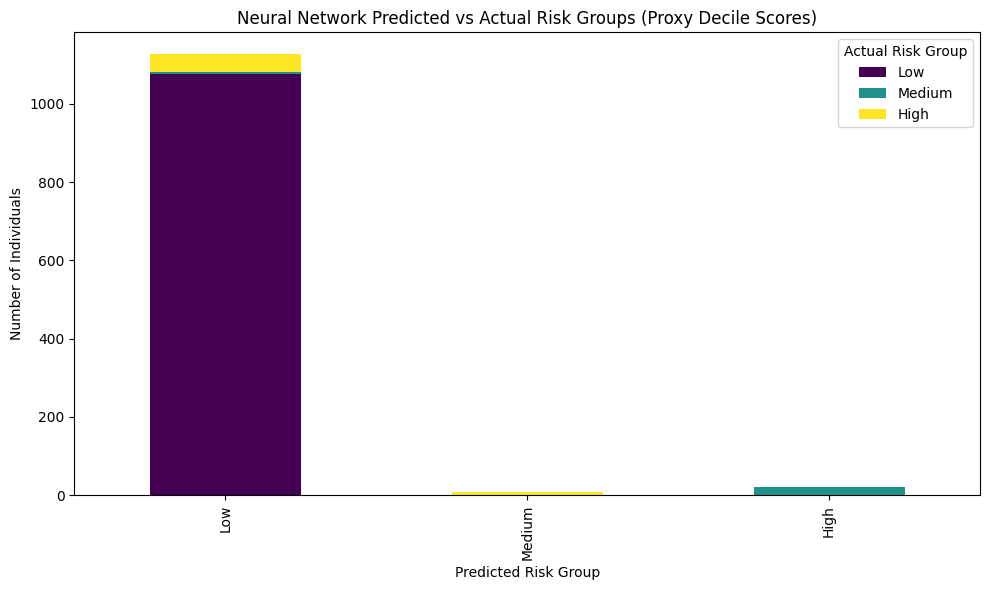

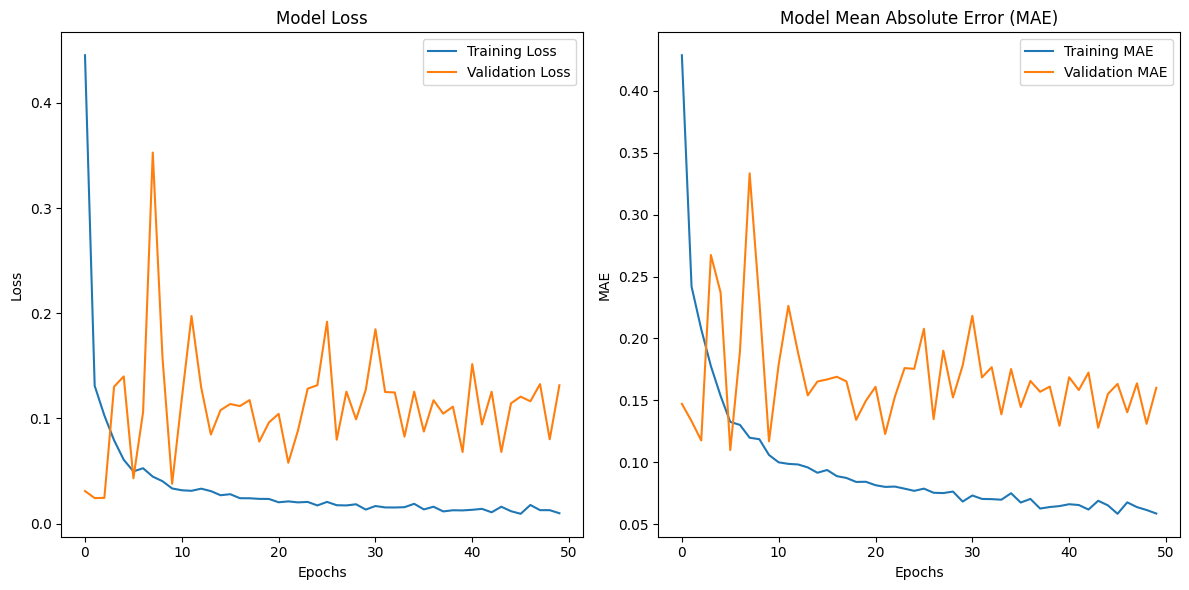

In [24]:

import tensorflow as tf



# Feature Engineering
df_train["history_of_violence"] = (
    df_train["juv_fel_count"] + df_train["juv_misd_count"] + df_train["juv_other_count"] + df_train["priors_count"]
)
df_train["socioeconomic_stability"] = (1 / (1 + df_train["priors_count"]))  # Proxy for stability

# Define a proxy target for decile score
df_train["proxy_decile_score"] = (
    0.5 * df_train["priors_count"] +
    0.3 * df_train["history_of_violence"] +
    0.2 * df_train["two_year_recid"]
)

# Normalize the proxy decile score to the range [1, 10]
df_train["proxy_decile_score"] = 1 + 9 * (df_train["proxy_decile_score"] - df_train["proxy_decile_score"].min()) / \
                                   (df_train["proxy_decile_score"].max() - df_train["proxy_decile_score"].min())

# Select relevant features and target
X = df_train[
    ["age", "priors_count", "history_of_violence", "days_b_screening_arrest",
     "socioeconomic_stability", "c_charge_degree_F", "c_charge_degree_M"]
]
y = df_train["proxy_decile_score"]  # Use the proxy decile score as the target

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the TensorFlow model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')  # Linear activation for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # Use Mean Squared Error for regression

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

# Evaluate the model on test data
loss, mae = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Loss (MSE): {loss:.4f}")
print(f"Test Mean Absolute Error (MAE): {mae:.4f}")

# Make predictions
y_pred = model.predict(X_test_scaled).flatten()

# Clip predictions to the range [1, 10] to resemble decile scores
y_pred_clipped = np.clip(y_pred, 1, 10)

# Evaluate the predictions
mse = mean_squared_error(y_test, y_pred_clipped)
r2 = r2_score(y_test, y_pred_clipped)
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared Score: {r2:.4f}")

# Add predictions to DataFrame for analysis
df_test = X_test.copy()
df_test["Actual_Proxy_Score"] = y_test.values
df_test["Predicted_Proxy_Score"] = y_pred_clipped

# Categorize into risk groups (Low, Medium, High)
def categorize_proxy(score):
    if score <= 4:
        return "Low"
    elif 5 <= score <= 7:
        return "Medium"
    else:
        return "High"

df_test["Actual_Risk_Group"] = pd.Categorical(
    df_test["Actual_Proxy_Score"].map(categorize_proxy), categories=["Low", "Medium", "High"], ordered=True
)
df_test["Predicted_Risk_Group"] = pd.Categorical(
    df_test["Predicted_Proxy_Score"].map(categorize_proxy), categories=["Low", "Medium", "High"], ordered=True
)

# Analysis of Predicted vs Actual Risk Groups
predicted_grouped = df_test.groupby(["Predicted_Risk_Group", "Actual_Risk_Group"]).size().unstack(fill_value=0)

# Save results to CSV
predicted_grouped.to_csv("tf_predicted_vs_actual_proxy_summary.csv")

# Print summary table
print("Predicted Risk Group vs Actual Risk Group Summary:")
print(predicted_grouped)

# Visualization: Predicted vs Actual Risk Groups
predicted_grouped.plot(
    kind="bar",
    stacked=True,
    colormap="viridis",
    figsize=(10, 6),
    title="Neural Network Predicted vs Actual Risk Groups (Proxy Decile Scores)"
)
plt.xlabel("Predicted Risk Group")
plt.ylabel("Number of Individuals")
plt.legend(title="Actual Risk Group", loc="upper right")
plt.tight_layout()
plt.show()

# Visualize Training History
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error (MAE)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/50


/Users/carmelgafa/Documents/my-work/ics5510-project/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1339 - mae: 0.7082 - val_loss: 0.0677 - val_mae: 0.2254
Epoch 2/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - loss: 0.1389 - mae: 0.2597 - val_loss: 0.1264 - val_mae: 0.2467
Epoch 3/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - loss: 0.1064 - mae: 0.2130 - val_loss: 0.0533 - val_mae: 0.1575
Epoch 4/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - loss: 0.0663 - mae: 0.1723 - val_loss: 0.1157 - val_mae: 0.2463
Epoch 5/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 0.0627 - mae: 0.1523 - val_loss: 0.1087 - val_mae: 0.2254
Epoch 6/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - loss: 0.0542 - mae: 0.1395 - val_loss: 0.0733 - val_mae: 0.1553
Epoch 7/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - loss: 0.0484 - mae: 0.1289 - val_loss: 0.1485 - val_mae: 0.2246
Epoch 8/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 0.0443 - mae: 0.1183 - val_loss: 0.1397 - val_mae: 0.2177
Epoch 9/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

/var/folders/2h/y479tsnx7xsdv7jvrs2zpk540000gn/T/ipykernel_32953/3976371604.py:94: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  predicted_grouped = df_test.groupby(["Predicted_Risk_Group", "Actual_Risk_Group"]).size().unstack(fill_value=0)


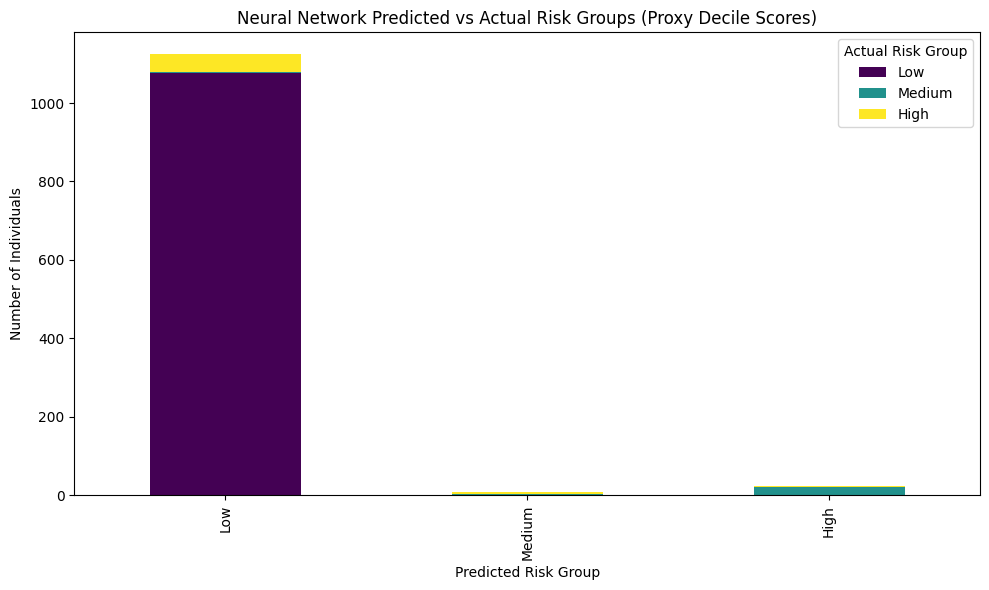

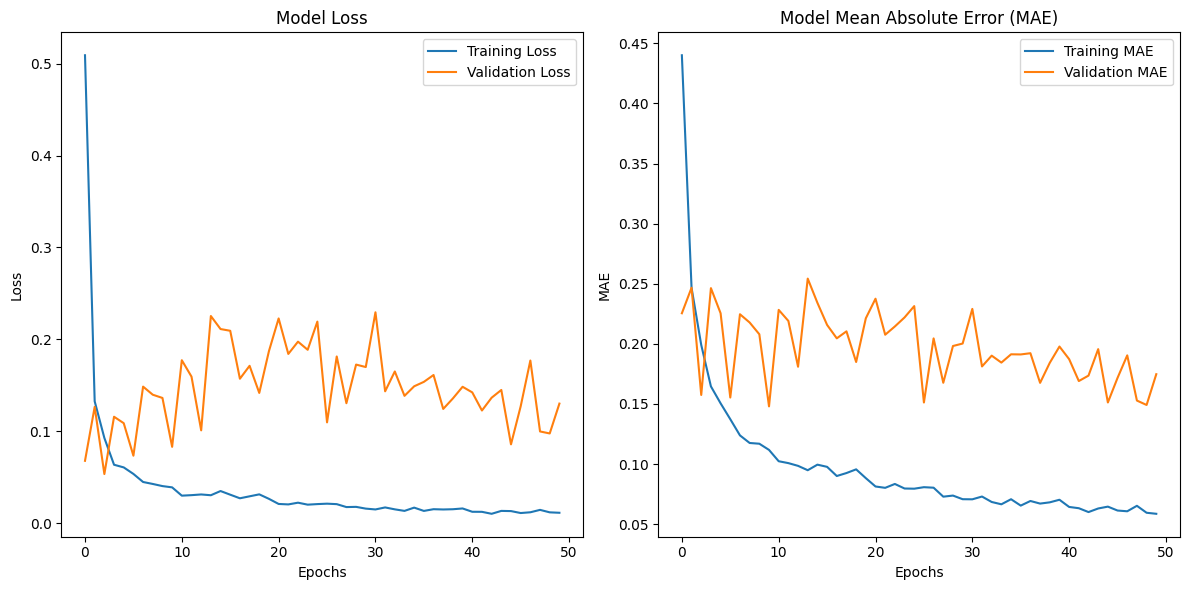

In [25]:


# Feature Engineering
df_train["history_of_violence"] = (
    df_train["juv_fel_count"] + df_train["juv_misd_count"] + df_train["juv_other_count"] + df_train["priors_count"]
)
df_train["socioeconomic_stability"] = (1 / (1 + df_train["priors_count"]))  # Proxy for stability

# Define a proxy target for decile score
df_train["proxy_decile_score"] = (
    0.5 * df_train["priors_count"] +
    0.3 * df_train["history_of_violence"] +
    0.2 * df_train["two_year_recid"]
)

# Normalize the proxy decile score to the range [1, 10]
df_train["proxy_decile_score"] = 1 + 9 * (df_train["proxy_decile_score"] - df_train["proxy_decile_score"].min()) / \
                                   (df_train["proxy_decile_score"].max() - df_train["proxy_decile_score"].min())

# Select relevant features and target
X = df_train[
    ["age", "priors_count", "history_of_violence", "days_b_screening_arrest",
     "socioeconomic_stability", "c_charge_degree_F", "c_charge_degree_M"]
]
y = df_train["proxy_decile_score"]  # Use the proxy decile score as the target

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the TensorFlow model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')  # Linear activation for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # Use Mean Squared Error for regression

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

# Evaluate the model on test data
loss, mae = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Loss (MSE): {loss:.4f}")
print(f"Test Mean Absolute Error (MAE): {mae:.4f}")

# Make predictions
y_pred = model.predict(X_test_scaled).flatten()

# Clip predictions to the range [1, 10] to resemble decile scores
y_pred_clipped = np.clip(y_pred, 1, 10)

# Evaluate the predictions
mse = mean_squared_error(y_test, y_pred_clipped)
r2 = r2_score(y_test, y_pred_clipped)
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared Score: {r2:.4f}")

# Add predictions to DataFrame for analysis
df_test = X_test.copy()
df_test["Actual_Proxy_Score"] = y_test.values
df_test["Predicted_Proxy_Score"] = y_pred_clipped

# Categorize into risk groups (Low, Medium, High)
def categorize_proxy(score):
    if score <= 4:
        return "Low"
    elif 5 <= score <= 7:
        return "Medium"
    else:
        return "High"

df_test["Actual_Risk_Group"] = pd.Categorical(
    df_test["Actual_Proxy_Score"].map(categorize_proxy), categories=["Low", "Medium", "High"], ordered=True
)
df_test["Predicted_Risk_Group"] = pd.Categorical(
    df_test["Predicted_Proxy_Score"].map(categorize_proxy), categories=["Low", "Medium", "High"], ordered=True
)

# Analysis of Predicted vs Actual Risk Groups
predicted_grouped = df_test.groupby(["Predicted_Risk_Group", "Actual_Risk_Group"]).size().unstack(fill_value=0)

# Save results to CSV
predicted_grouped.to_csv("tf_predicted_vs_actual_proxy_summary.csv")

# Print summary table
print("Predicted Risk Group vs Actual Risk Group Summary:")
print(predicted_grouped)

# Visualization: Predicted vs Actual Risk Groups
predicted_grouped.plot(
    kind="bar",
    stacked=True,
    colormap="viridis",
    figsize=(10, 6),
    title="Neural Network Predicted vs Actual Risk Groups (Proxy Decile Scores)"
)
plt.xlabel("Predicted Risk Group")
plt.ylabel("Number of Individuals")
plt.legend(title="Actual Risk Group", loc="upper right")
plt.tight_layout()
plt.show()

# Visualize Training History
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error (MAE)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/50


/Users/carmelgafa/Documents/my-work/ics5510-project/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4423 - mae: 0.7705 - val_loss: 0.0439 - val_mae: 0.1728
Epoch 2/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 0.1551 - mae: 0.2733 - val_loss: 0.0381 - val_mae: 0.1719
Epoch 3/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - loss: 0.1038 - mae: 0.2246 - val_loss: 0.0388 - val_mae: 0.1670
Epoch 4/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - loss: 0.0799 - mae: 0.1926 - val_loss: 0.1299 - val_mae: 0.2845
Epoch 5/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - loss: 0.0712 - mae: 0.1770 - val_loss: 0.0860 - val_mae: 0.2407
Epoch 6/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - loss: 0.0552 - mae: 0.1525 - val_loss: 0.0332 - val_mae: 0.1215
Epoch 7/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - loss: 0.0550 - mae: 0.1385 - val_loss: 0.0111 - val_mae: 0.0712
Epoch 8/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 0.0409 - mae: 0.1222 - val_loss: 0.0877 - val_mae: 0.1867
Epoch 9/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step

/var/folders/2h/y479tsnx7xsdv7jvrs2zpk540000gn/T/ipykernel_32953/2640185870.py:86: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  race_split_analysis = df_test.groupby(["race", "Predicted_Risk_Group", "two_year_recid"]).size().unstack(fill_value=0)


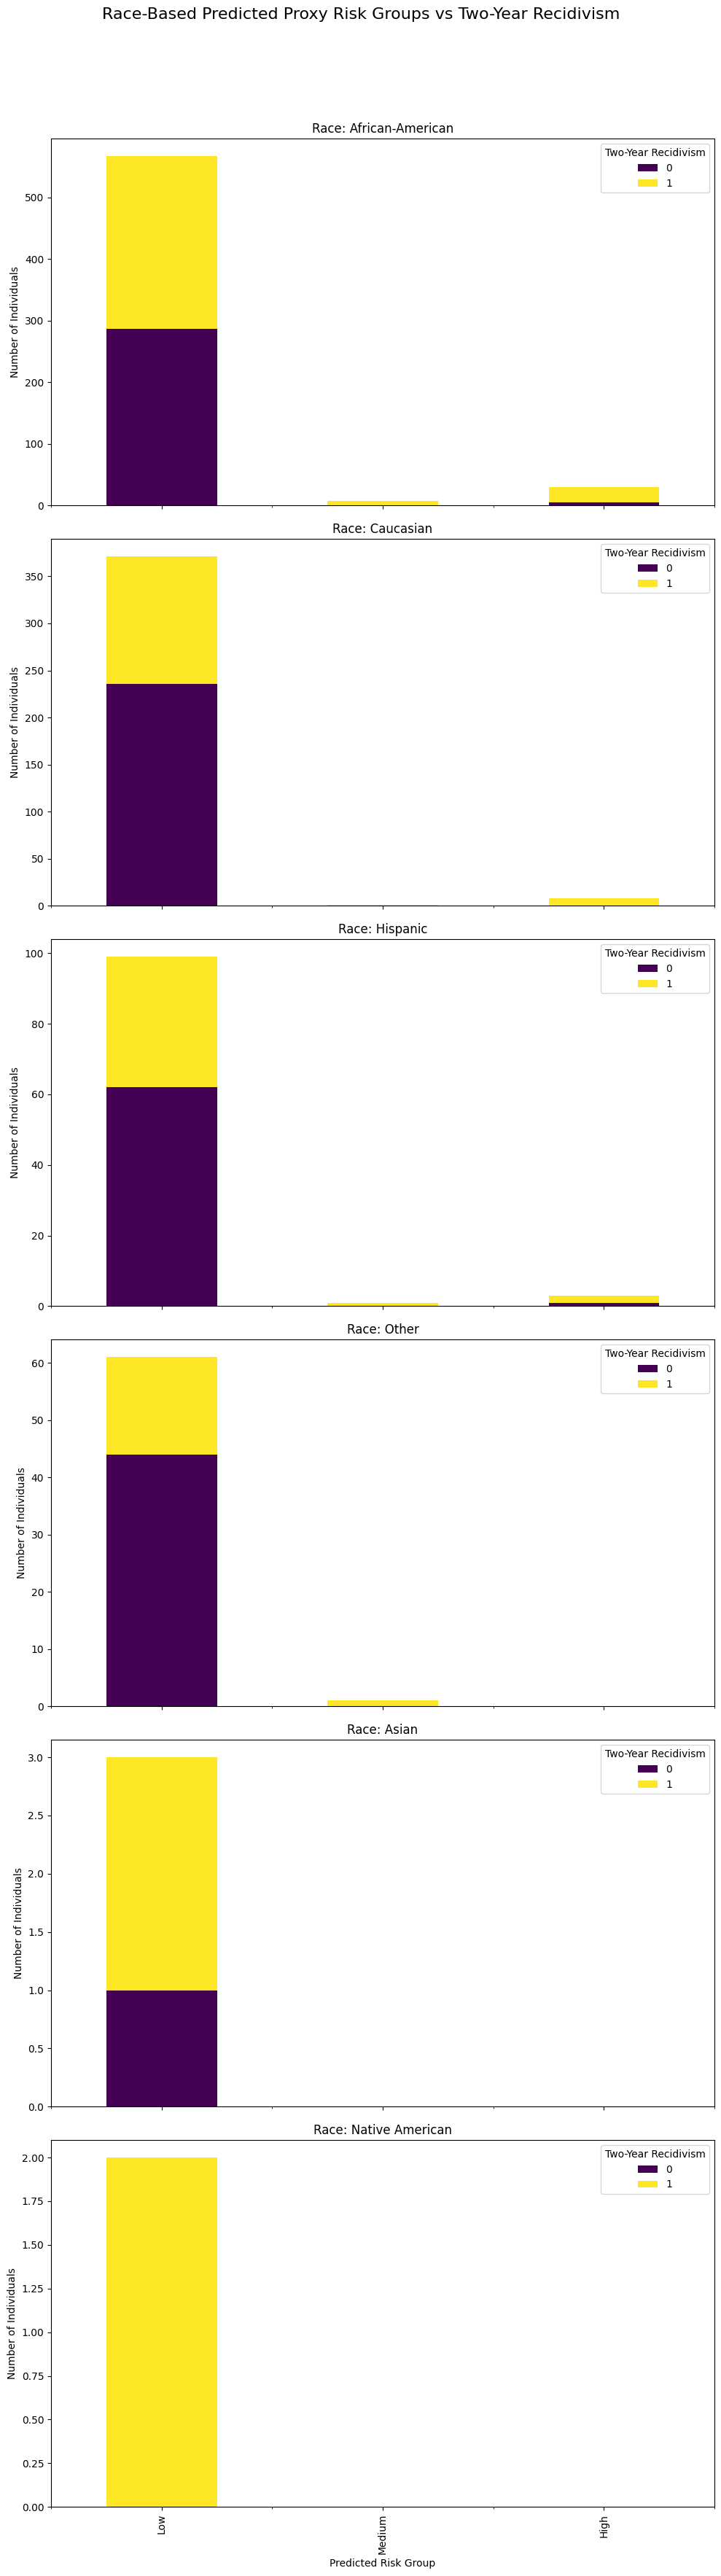

In [26]:


# Feature Engineering
df_train["history_of_violence"] = (
    df_train["juv_fel_count"] + df_train["juv_misd_count"] + df_train["juv_other_count"] + df_train["priors_count"]
)
df_train["socioeconomic_stability"] = (1 / (1 + df_train["priors_count"]))  # Proxy for stability

# Define a proxy target for decile score (based on priors, violence history, and recidivism)
df_train["proxy_decile_score"] = (
    0.5 * df_train["priors_count"] +
    0.3 * df_train["history_of_violence"] +
    0.2 * df_train["two_year_recid"]
)

# Normalize the proxy decile score to the range [1, 10]
df_train["proxy_decile_score"] = 1 + 9 * (df_train["proxy_decile_score"] - df_train["proxy_decile_score"].min()) / \
                                   (df_train["proxy_decile_score"].max() - df_train["proxy_decile_score"].min())

# Select relevant features and target
X = df_train[
    ["age", "priors_count", "history_of_violence", "days_b_screening_arrest",
     "socioeconomic_stability", "c_charge_degree_F", "c_charge_degree_M"]
]
y = df_train["proxy_decile_score"]  # Use the proxy decile score as the target

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the TensorFlow model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')  # Linear activation for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # Use Mean Squared Error for regression

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

# Evaluate the model on test data
loss, mae = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Loss (MSE): {loss:.4f}")
print(f"Test Mean Absolute Error (MAE): {mae:.4f}")

# Make predictions
y_pred = model.predict(X_test_scaled).flatten()

# Clip predictions to the range [1, 10] to resemble decile scores
y_pred_clipped = np.clip(y_pred, 1, 10)

# Add predictions to DataFrame for analysis
df_test = X_test.copy()
df_test["two_year_recid"] = df_train.loc[X_test.index, "two_year_recid"].values
df_test["race"] = df_train.loc[X_test.index, "race"].values
df_test["Predicted_Proxy_Score"] = y_pred_clipped

# Categorize predictions into risk groups (Low, Medium, High)
def categorize_proxy(score):
    if score <= 4:
        return "Low"
    elif 5 <= score <= 7:
        return "Medium"
    else:
        return "High"

df_test["Predicted_Risk_Group"] = pd.Categorical(
    df_test["Predicted_Proxy_Score"].map(categorize_proxy), categories=["Low", "Medium", "High"], ordered=True
)


# Group by Predicted Risk Group, Two-Year Recidivism, and Race
race_split_analysis = df_test.groupby(["race", "Predicted_Risk_Group", "two_year_recid"]).size().unstack(fill_value=0)

# Save results to CSV
race_split_analysis.to_csv("tf_proxy_vs_recid_by_race_summary.csv")

# Print summary table
print("Race-Based Predicted Proxy Risk Group vs Two-Year Recidivism Summary:")
print(race_split_analysis)

# Visualization: Race-Based Predicted Proxy Risk Groups vs Two-Year Recidivism
races = df_test["race"].unique()
fig, axes = plt.subplots(len(races), 1, figsize=(10, 6 * len(races)), sharex=True)
plt.suptitle("Race-Based Predicted Proxy Risk Groups vs Two-Year Recidivism", fontsize=16)

for i, race in enumerate(races):
    race_data = race_split_analysis.loc[race]
    race_data.plot(
        kind="bar",
        stacked=True,
        ax=axes[i],
        colormap="viridis",
        title=f"Race: {race}"
    )
    axes[i].set_ylabel("Number of Individuals")
    axes[i].legend(title="Two-Year Recidivism", loc="upper right")

plt.xlabel("Predicted Risk Group")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

